### 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

#### Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer


Question:
"What’s 15 × 27?"

Model’s first answer:

405

Self-reflection:

Recalculate step by step:

15 × 20 = 300

15 × 7 = 105

300 + 105 = 405 ✅

Confirm correct → no revision needed.

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END

In [15]:
### load llm models
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [5]:
docs = TextLoader("research_notes.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [6]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [7]:
# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [8]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""
Reflect on the following answer to see if it fully addresses the question. 
State YES if it is complete and correct, or NO with an explanation.

Question: {state.question}

Answer: {state.answer}

Respond like:
Reflection: YES or NO
Explanation: ...
"""
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [9]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

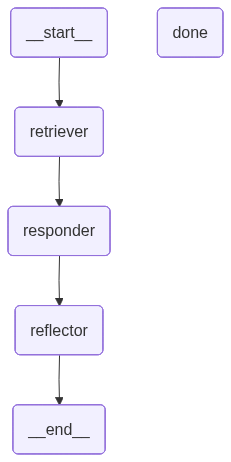

In [12]:
# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
)

builder.add_edge("done", END)
graph = builder.compile()

graph

In [14]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "When to use TinyBERT?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 TinyBERT is particularly suitable for use in support ticket systems, specifically for the task of classifying and tagging the priority of support tickets. It has been evaluated to have an 87% F1 score, which indicates good performance, although it shows some confusion in handling an ambiguous class C. Additionally, TinyBERT adapts well to domain changes using a 2-layer Feedforward Neural Network (FFN) adapter, indicating its flexibility in adapting to different environments and datasets. Therefore, if you are dealing with support ticket systems and need a model for priority tagging, TinyBERT is an appropriate choice, especially when there is a need for some level of domain transferability.

🔁 Reflection Log:
 Reflection: NO  
Explanation: The answer provided gives a specific instance where TinyBERT can be used—support ticket systems for classifying and tagging priorities—and discusses its performance in this particular use case. However, it misses mentioning other sce